In [1]:
import math
import matplotlib.pyplot as plt
import operator
import torch
from functools import partial

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['font.size'] = 8

In [4]:
torch.manual_seed(11)
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)

## Meanshift clustering algorithm
>The idea is to use the concepts of broadcasting, multiplication, gpu acceleration in the implementation

### create the data

In [6]:
n_clusters = 5
n_samples = 300

In [7]:
centroids = torch.rand(n_clusters, 2)*100-50

In [8]:
centroids

tensor([[-35.09583,  -1.34469],
        [ 48.56615, -33.15986],
        [  8.39434,  19.35992],
        [  8.30849, -37.15622],
        [  7.21227,  42.48394]])

In [9]:
centroids.shape

torch.Size([5, 2])

In [10]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

>We'll use a multivariate normal distribution, here bivariate, to generate points $(x_i, y_i)$ around the centroids, the variables won't be correlated so the covariance matrix should be diagonal, with variance $v$ each:<br>
*(The first argument is the mean, ie a centroid, and the second argument is the covariance matrix (here diagonal), then in the sample() method we specify the number of points to draw around this mean with the variance given in the covariance matrix)*

In [11]:
v = 30.0
u = MultivariateNormal(centroids[0], torch.diag(tensor([v,v])))

In [12]:
g = u.sample((n_samples,))

In [13]:
g.shape

torch.Size([300, 2])

In [14]:
def sample(m, v): return MultivariateNormal(m, torch.diag(tensor([v,v]))).sample((n_samples,))

In [15]:
v = 11.

In [16]:
clouds = [sample(c, v) for c in centroids]
data = torch.cat(clouds)
data.shape

torch.Size([1500, 2])

In [17]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: fig,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        sample = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(sample[:,0], sample[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker='x', color='r', mew=1)

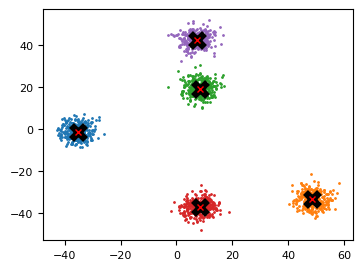

In [18]:
plot_data(centroids, data, n_samples)

### Mean Shift
> This algorithm does not need to know the number of centroids in advance, it requires a **bandwidth**, similarly to dbscan. <br>
And it works with clusters of any shape.

> What we are looking to do is measure the distance between each point and the rest of the points and weight each two-by-two distance with the gaussian. A neighbor point will have a weight closer to 1 vs a far away point will have a weight tht tends towards 0.

> We can try various function shapes and see how they compare in efficiency. If we want the weighting to be normed, the function should integrate to 1

> Then, we will assign the weighted average x and weighted average

In [19]:
#barycentre
data.mean(0)

tensor([ 7.36041, -1.81920])

> We typically use a gaussian function: <br>
\begin{equation*}
\mathcal{N}(0,\,\sigma^{2}) = \frac{1}{\sqrt{2\pi} \sigma} \exp \left(-{\frac{x^2}{2\sigma^2}}\right)
\end{equation*}

>But other functions can work as well. The gaussian's standard deviation will be the bandwidth, meaning the characteristic distance within which a point will have an impact in the weighted sum. Another possibility would be to use a trianfular function, an inverse function, or a decreasing exponential function.

In [20]:
def gaussian(x, sig=2.5) : 
    return 1/(sig*(2*math.pi)**(0.5)) * torch.exp(-0.5*(x/sig)**2)

In [21]:
def tri(x, i=8):
    return (-(abs(x)/i)+1).clamp_min(0)

In [22]:
def exp_n(x, t=2.5):
    return torch.exp(-abs(x)/t)

In [146]:
def plot_func(f):
    x = torch.linspace(0,50,100)
    plt.plot(x, f(x))

> In order to use partially defined function as input of `plot_func()` we can use the `partial` method from `functools`. We can pass in the function name and specify the attributes we want to fix:

In [24]:
partial

functools.partial

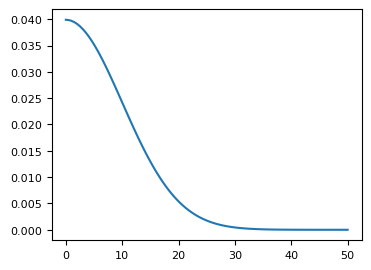

In [147]:
plot_func(partial(gaussian, sig=10))

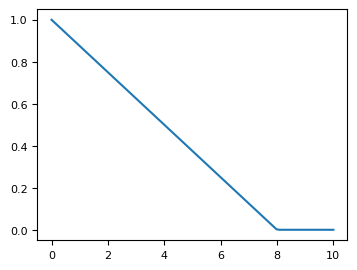

In [26]:
plot_func(tri)

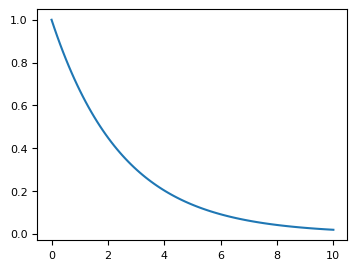

In [27]:
plot_func(partial(exp_n,t=2.5))

In [28]:
X = data.clone()
X = X[torch.randperm(X.shape[0])]
x = data[0]

In [29]:
x.shape, X.shape, (x-X).shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1500, 2]))

>We can use a loop to calculate all values from the matrix X:

In [29]:
%%timeit
dist = torch.zeros(X.shape[0], X.shape[0])
for i,x in enumerate(X):
    dist[i] = ((x-X)**2).sum(1).sqrt()

193 ms ± 5.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


> We can remove the loop and fasten the process by using a complete vectorial calculation:

In [30]:
X[...,None].shape, X.shape

(torch.Size([1500, 2, 1]), torch.Size([1500, 2]))

In [31]:
%timeit -n 2 ((X[...,None]-X.transpose(0,1))**2).sum(1).sqrt()

17.9 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


> In order to remove the transpose step we can add the empty axis in between, the same broadcasting rule will apply:

In [32]:
X[:,None,:].shape, X.shape

(torch.Size([2500, 1, 2]), torch.Size([2500, 2]))

In [33]:
%timeit -n 2 ((X[:,None,:]-X)**2).sum(2).sqrt()

39.1 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


> We can try with `torch.einsum` as well:

In [34]:
%%timeit
Xt = torch.einsum('ij->ji', X)
Diff2 = (X[...,None] - Xt)**2
Dist = torch.einsum('ijk->ik', Diff2).sqrt()

39.9 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%timeit -n 2 Dist = torch.einsum('ijk->ik', (X[...,None] - torch.einsum('ij->ji', X))**2).sqrt()

42.3 ms ± 5.65 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [36]:
%timeit -n 2 torch.sqrt(torch.einsum('ijk->ij',(X[:,None,:] - X)**2))

37.2 ms ± 4.6 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


> We can add the square step in einsum and the performance is the best:

In [37]:
%%timeit
Diff = X[:,None,:] - X
torch.sqrt(torch.einsum('ijk,ijk->ij',Diff,Diff))

25 ms ± 809 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


> The fastest implementation in a function with the weighting function:

In [32]:
def calculate_weights(M, distrib):
    D = M[:,None,:] - M
    return distrib(torch.sqrt(torch.einsum('ijk,ijk->ij',D,D)))

In [39]:
weights = calculate_weights(X, gaussian)

In [40]:
weights

tensor([[    0.15958,     0.00000,     0.00000,  ...,     0.02073,     0.06337,     0.01029],
        [    0.00000,     0.15958,     0.00000,  ...,     0.00000,     0.00000,     0.00000],
        [    0.00000,     0.00000,     0.15958,  ...,     0.00000,     0.00000,     0.00000],
        ...,
        [    0.02073,     0.00000,     0.00000,  ...,     0.15958,     0.00406,     0.00010],
        [    0.06337,     0.00000,     0.00000,  ...,     0.00406,     0.15958,     0.00049],
        [    0.01029,     0.00000,     0.00000,  ...,     0.00010,     0.00049,     0.15958]])

> The next operation performs the weighted average $\frac{\sum_{i=0}^{n} \omega_i xi}{\sum_{i=0}^{n} \omega_i}$ for each point and replaces the weighted average of $x_i$ and $y_i$ by their new weighted average *(the einsum implementation is again much faster)* :

In [41]:
weights.shape, X.shape

(torch.Size([2500, 2500]), torch.Size([2500, 2]))

In [42]:
(X*weights[...,None]).sum(1).shape, weights.sum(1)[:,None].shape

(torch.Size([2500, 2]), torch.Size([2500, 1]))

In [43]:
%timeit -n 2 ((X*weights[...,None]).sum(1))/(weights.sum(0)[:,None])

14.8 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [44]:
%timeit -n 2 torch.einsum('jk,ijk->ik', X, weights[...,None])/torch.einsum('ij->j',weights)[:,None]

5.23 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [45]:
X

tensor([[ 48.95474, -31.34707],
        [  8.45164,  22.63295],
        [ 16.60374, -35.53895],
        ...,
        [ 44.28896, -33.28213],
        [ 51.02065, -34.04449],
        [ 50.03633, -25.59400]])

In [33]:
def calc_w(X, distrib):
    wei_X = torch.zeros(X.shape[0], X.shape[0])
    X_new = torch.zeros_like(X)
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist,2.5)
        wei_X[i] = weight
        X_new[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return X_new, wei_X

In [34]:
def update_X(X, W): return torch.einsum('jk,ijk->ik', X, W[...,None])/torch.einsum('ij->j',W)[:,None]  
# def update_X(W, X): return((X*W[...,None]).sum(1))/(W.sum(0)[:,None])

In [48]:
r_s,_ = calc_w(X, gaussian)
r_s, _ = calc_w(r_s, gaussian)
r_s

tensor([[ 48.66008, -32.51586],
        [  8.59818,  20.22630],
        [ 10.90796, -36.77404],
        ...,
        [ 47.13900, -33.11506],
        [ 49.26615, -33.19857],
        [ 49.27081, -30.88627]])

In [49]:
w = calculate_weights(X, gaussian)
r_v = update_X(X, w)
w = calculate_weights(r_v, gaussian)
r_v = update_X(r_v, w)
r_v

tensor([[ 48.66008, -32.51586],
        [  8.59818,  20.22630],
        [ 10.90796, -36.77403],
        ...,
        [ 47.13899, -33.11507],
        [ 49.26615, -33.19857],
        [ 49.27081, -30.88627]])

In [50]:
(r_s-r_v).sum()

tensor(0.00065)

In [51]:
%%timeit -n 2
weights = calculate_weights(X, gaussian)
update_X(X, weights)

78.7 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [97]:
def meanshift(data, func):
    X = data.clone()
    for i in range(3):
        weights = calculate_weights(X, func)
        X = update_X(X, weights)
    return X

In [53]:
%timeit -n 2 X=meanshift(data, gaussian)

182 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [98]:
X = meanshift(data, gaussian)

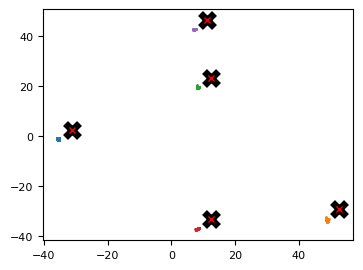

In [99]:
plot_data(centroids+4, X, n_samples)

> We can build the following function that breaks down the operation point by point to verify the results above: <br>
(It is a very slow operation)

In [56]:
# def calc_w(X, distrib):
#     wei_X = torch.zeros(X.shape[0], X.shape[0])
#     X_new = torch.zeros_like(X)
#     for i,x in enumerate(X):
#         dist = ((x-X)**2).sum(1).sqrt()
#         weight = gaussian(dist,2.5)
#         wei_X[i] = weight
#         X_new[i] = (weight[:,None]*X).sum(0)/weight.sum()
#     return X_new, wei_X

In [38]:
# Sequential version with the points position update performed at the end of the full loop
def calc_w(X, distrib):
    X_new = torch.zeros_like(X)
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist,2.5)
        X_new[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return X_new

In [39]:
# Jeremy's version with the running update in the for loop
def one_update(X):
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist,2.5)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [59]:
%time calc_w(X, gaussian)

CPU times: user 253 ms, sys: 288 µs, total: 254 ms
Wall time: 253 ms


tensor([[-35.20648,  -1.56982],
        [-35.20646,  -1.56913],
        [-35.20636,  -1.57091],
        ...,
        [  7.23291,  42.58536],
        [  7.23032,  42.58460],
        [  7.23070,  42.58479]])

In [40]:
def meanshift_slow(data):
    X = data.clone()
    for it in range(3): X = calc_w(X, gaussian)
#     for it in range(3): one_update(X)
    return X

In [61]:
%time _=meanshift_slow(data)

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


In [41]:
X = meanshift_slow(data)

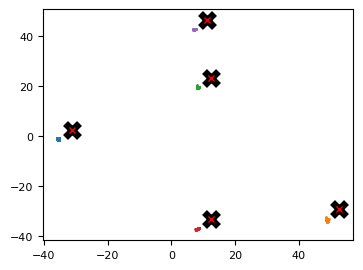

In [42]:
plot_data(centroids+4, X, n_samples)

CHECK THE PERFORMANCE OF THE VECT ALGO AND JEREMYS, HOW ARE THE POINTS POOLED...

### We can animate the process

In [54]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [79]:
def do_one(d):
    

SyntaxError: incomplete input (3576810337.py, line 2)

### Using Rtrees and Locality-Sensitive Hashing

> Rtrees should not be of great help here because if we need to use only the nearest neighbors of each points to spare on the distance calculation, the nearest neighbor search is expensive and must be performed at each meanshift iteration since the points coordinates are modified.
Meanshift uses nicely the vectorial speed and replaces the nearest neighbors search by the gaussian distribution and weighted average tricks.

> On the contrary, DBSCAN in a sequential implementation should likely benefit from RTrees and LSH

#### RTrees

In [80]:
from rtree import index

In [81]:
idx = index.Index()

for i,coord in enumerate(X):
    idx.add(i, (*coord, *coord))

In [82]:
for k in range(10):
    nearest = list(idx.nearest(X[k], 2))
    nn = nearest[1]
    dist = torch.sqrt(torch.sum((X[nn]-X[k])**2))
    print (k, nn, dist)

0 53 tensor(0.00257)
1 6 tensor(0.01940)
2 85 tensor(0.00240)
3 82 tensor(0.00181)
4 110 tensor(0.00321)
5 59 tensor(0.00639)
6 27 tensor(0.00605)
7 9 tensor(0.00380)
8 48 tensor(0.00452)
9 55 tensor(0.00228)


In [224]:
tensor(list(idx.nearest(X[0], 10)))

tensor([  0,  63, 157,  61, 167, 188, 703, 142, 357,  23])

In [52]:
(X[:,None,:]-X).shape

torch.Size([10500, 10500, 2])

We can add all points to the index with a for loop:

In [38]:
def build_idx(X):
    idx = index.Index()
    for i,coord in enumerate(X):
        idx.add(i, (*coord, *coord))
    return idx

In [544]:
%timeit -n 10 build_idx(X)

822 ms ± 28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Or we can create a custom iterator to build the right data shape `(id, (minx, maxx, miny, maxy, minz, maxz, ..., ..., mink, maxk), object)` expected by the `index` object:

In [39]:
class Idx_format():
    def __init__(self, Xs):
        self.Xs = Xs
        self.step = 0
        self.max_step = Xs.shape[0]
        
    def __iter__(self):
        return self
        
    def __next__(self):
        if self.step >= self.max_step:
            raise StopIteration
        self.dat = (self.step, (*self.Xs[self.step], *self.Xs[self.step]), None)
        self.step += 1
        return self.dat

In [55]:
X_it = iter(Idx_format(X))
X_it_l = list(X_it)
X_it_l[:2]

[(0,
  (tensor(-63.21973), tensor(-2.42087), tensor(-63.21973), tensor(-2.42087)),
  None),
 (1,
  (tensor(-63.13456), tensor(-2.41613), tensor(-63.13456), tensor(-2.41613)),
  None)]

In [40]:
def build_idx(X):
    idx = index.Index()
    X_it = iter(Idx_format(X))
    idx = index.Index(list(X_it))
    return idx

In [547]:
%timeit -n 10 build_idx(X)

195 ms ± 6.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can build the nearest neighbors matrix `NN_matrix`:

- with a loop:

In [41]:
def NN_matrix(X, idx, k):
    X_nn = torch.zeros(X.shape[0], k, 2)
    for i in range(X.shape[0]):
        idxnn = list(idx.nearest(X[i], k))
        X_nn[i] = X[idxnn][:k]
    return X_nn

In [542]:
%time _ = NN_matrix(X, idx, 10) 

CPU times: user 2.85 s, sys: 99.6 ms, total: 2.95 s
Wall time: 2.36 s


- with a list comprehension:

In [537]:
%time _ = torch.stack([X[list(idx.nearest(X[i], 10))][:10] for i in range(X.shape[0])])

CPU times: user 2.39 s, sys: 0 ns, total: 2.39 s
Wall time: 2.39 s


- with a custom iterator:

In [42]:
class nn_iter():
    def __init__(self, X, idx, k):
        self.X, self.idx, self.k = X, idx, k
        self.step = 0
        self.max_step = X.shape[0]
    def __iter__(self):
        return self
    def __next__(self):
        if self.step >= self.max_step: raise StopIteration
        idxnn = list(self.idx.nearest(self.X[self.step], self.k))
        nns = self.X[idxnn][:self.k]
        self.step += 1
        return nns

In [43]:
def NN_matrix_i(X, idx, k): return torch.stack(list(iter(nn_iter(X,idx,k))))

In [540]:
%time _ = NN_matrix_i(X,idx,10)

CPU times: user 2.49 s, sys: 0 ns, total: 2.49 s
Wall time: 2.49 s


They are more or less similar, the simple loop seems slightly faster. The bottleneck is the `index.Index().nearest()` method.

In [60]:
X_nn = NN_matrix(X, idx, 50) 

In [61]:
X_nn.shape, X.shape

(torch.Size([10500, 50, 2]), torch.Size([10500, 2]))

In [62]:
((X[:,None,:] - X_nn)[5]**2)[:5]

tensor([[    0.00000,     0.00000],
        [    0.00016,     0.00036],
        [    0.00006,     0.00055],
        [    0.00000,     0.00100],
        [    0.00061,     0.00043]])

In [63]:
((X[:,None,:] - X_nn)**2).sum(2).shape

torch.Size([10500, 50])

Now we use the same weight calculation function:

In [44]:
def NN_weights(X, X_nn, distrib):
    D = X[:,None,:] - X_nn
    return distrib(torch.sqrt(torch.einsum('ijk,ijk->ij',D,D)))

In [550]:
%timeit -n 10 NN_weights(X, X_nn, gaussian)

3.73 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
w_nn = NN_weights(X, X_nn, gaussian)
w_nn.shape, w_nn.unique().shape

(torch.Size([10500, 50]), torch.Size([16484]))

In [66]:
X_nn.shape

torch.Size([10500, 50, 2])

In [67]:
(X_nn*w_nn[...,None]).sum(1).shape, w_nn.sum(1).shape

(torch.Size([10500, 2]), torch.Size([10500]))

In [68]:
(X_nn*w_nn[...,None]).sum(1)/w_nn.sum(1)[:,None]

tensor([[-63.21939,  -2.42252],
        [-63.13619,  -2.41427],
        [-63.08471,  -2.42567],
        ...,
        [-41.16182,  -6.74337],
        [-40.90976,  -6.57574],
        [-41.00322,  -6.58272]])

Finally the update function:

In [45]:
def update_X_nn(X_nn,W_nn): return torch.einsum('ijk,ijk->ik', X_nn, W_nn[...,None])/torch.einsum('ij->i',W_nn)[:,None] 

In [70]:
n_x = update_X_nn(X_nn, w_nn) 
n_x.shape, n_x

(torch.Size([10500, 2]),
 tensor([[-63.21939,  -2.42252],
         [-63.13620,  -2.41427],
         [-63.08472,  -2.42567],
         ...,
         [-41.16182,  -6.74337],
         [-40.90976,  -6.57574],
         [-41.00322,  -6.58272]]))

In [136]:
%%timeit -n 2
X = data.clone()

The slowest run took 110.95 times longer than the fastest. This could mean that an intermediate result is being cached.
103 µs ± 105 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [558]:
%%timeit -n 2
_ = build_idx(X)

189 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [559]:
%%timeit -n 2
_ = NN_matrix(X,idx,50)

3.41 s ± 88.3 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [560]:
%%timeit -n 2
_ = NN_weights(X, X_nn, gaussian)

5.45 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [561]:
%%timeit -n 2
_ = update_X_nn(X_nn, nn_w)

The slowest run took 7.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1.5 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [137]:
X = data.clone()
X = X[torch.randperm(X.shape[0])]

The bottleneck is the nearest neightbors matrix `NN_matrix()` calculation. The complete time for a 50 nn calculation is about 3.7s (and 100 nn about 4.57s) to be compared to 1.4s:

In [138]:
%%timeit -n 2
X = data.clone()
idx = build_idx(X)
X_nn = NN_matrix(X,idx,100)
nn_w = NN_weights(X, X_nn, gaussian)
X = update_X_nn(X_nn, nn_w)

NameError: name 'build_idx' is not defined

That said, the distance and distribution steps can be removed and an average of the nearest neighbors could be used:

In [46]:
def build_idx(X):
    idx = index.Index()
    X_it = iter(Idx_format(X))
    idx = index.Index(list(X_it))
    return idx

In [47]:
def NN_matrix(X, idx, k):
    X_nn = torch.zeros(X.shape[0], k, 2)
    for i in range(X.shape[0]):
        idxnn = list(idx.nearest(X[i], k))
        X_nn[i] = X[idxnn][:k]
    return X_nn

In [48]:
def update_X_nn_avg(X_nn): return torch.einsum('ijk->ik', X_nn)/X_nn.shape[1] 

In [571]:
%%timeit -n 2
X = data.clone()
idx = build_idx(X)
X_nn = NN_matrix(X,idx,100)
X = update_X_nn_avg(X_nn)

4.68 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [49]:
def meanshift_nn(data, func, k):
    X = data.clone()
    idx = build_idx(X)
    for i in range(3):
        X_nn = NN_matrix(X,idx,k)
        w_nn = NN_weights(X, X_nn, gaussian)
        X = update_X_nn(X_nn, w_nn)
    return X

In [387]:
%time meanshift_nn(data, gaussian, 500)

CPU times: user 27.3 s, sys: 313 ms, total: 27.6 s
Wall time: 25.4 s


In [76]:
X = meanshift_nn(data, gaussian, 500)

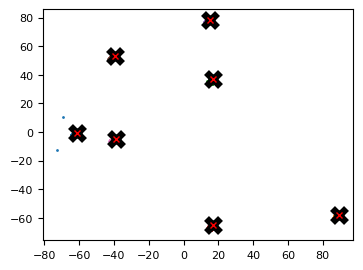

In [77]:
plot_data(centroids+2, X, n_samples)

In [78]:
X[[1,2,5]]

tensor([[-62.74137,  -2.96883],
        [-62.44592,  -2.95599],
        [-62.40714,  -1.49201]])

In [ ]:
def select_pts

In [50]:
def calculate_weights(X, distrib):
    D = X[:,None,:] - X
    return distrib(torch.sqrt(torch.einsum('ijk,ijk->ij',D,D)))

In [51]:
def update_X(X, W): return torch.einsum('jk,ijk->ik', X, W[...,None])/torch.einsum('ij->j',W)[:,None] 

In [52]:
def meanshift(data, func):
    X = data.clone()
    for i in range(3):
        weights = calculate_weights(X, func)
        X = update_X(weights, X)
    return X

#### Locality-Sensitive Hashing

In [43]:
n_cent = 5
n_p = 300
cent = torch.rand(n_cent, 2)*180-90
cent.shape, cent

(torch.Size([5, 2]),
 tensor([[ 71.71429,  72.26480],
         [-48.45341, -33.85703],
         [ 46.88916, -75.48917],
         [-75.72447, -67.15977],
         [ 84.09106,  31.25935]]))

In [44]:
def generate_points(c, n_pts, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [45]:
dat_l = [generate_points(c,n_p,50.) for c in cent]
dat = torch.cat(dat_l)

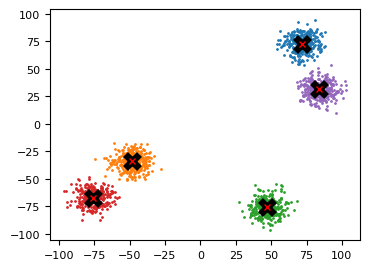

In [46]:
plot_data(cent,dat,n_p)

In [51]:
class Data_hash():
    def __init__(self, data, dim, n_hash, scale_factor=1): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        h_t = 2*torch.pi*torch.rand(n_hash)
        self.h_mat = torch.stack([torch.cos(h_t), -torch.sin(h_t)])
        self.h_b = torch.rand(n_hash)
        self.hashed = self._hash(data)
        
    def _hash(self, X): return torch.floor(X @ self.h_mat * self.s + self.h_b)
    
    def find_nns(self, x, n_matches): 
        v_collide = (self._hash(x) == self.hashed).sum(1)
        nns = torch.where(v_collide > n_matches)[0]
        return v_collide, nns 
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for a in self.h_mat[1]/self.h_mat[0]: 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

In [52]:
# X = data.clone()
X = dat.clone()
X = X[torch.randperm(X.shape[0])]

In [53]:
X_hash = Data_hash(X,X.shape[1],11)

In [54]:
def hash_X(X, n_h, sf=1): return Data_hash(X, X.shape[1], n_h, scale_factor=sf).hashed

In [55]:
%timeit -n 5 _ = hash_X(X, 11)

The slowest run took 4.74 times longer than the fastest. This could mean that an intermediate result is being cached.
149 µs ± 117 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Getting the nearest neighbors with torch.where or any other boolean tensor operation is slow because the number of hash values is `n_hash` is quite large.
We for 
We could think of ways to perform

In [220]:
%timeit -n 10 tri(X,0.1)

The slowest run took 6.90 times longer than the fastest. This could mean that an intermediate result is being cached.
56.9 µs ± 61.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [67]:
%timeit -n 10 gaussian(X,0.1)

118 µs ± 70 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
%timeit -n 10 exp_n(X, 10)

The slowest run took 12.07 times longer than the fastest. This could mean that an intermediate result is being cached.
45.1 µs ± 64.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
X_hash.hashed[:,None,:].shape, X_hash.hashed.shape

(torch.Size([1500, 1, 11]), torch.Size([1500, 11]))

In [36]:
%timeit -n 10 tri((X_hash.hashed[:,None,:] - X_hash.hashed), 0.1)

234 ms ± 9.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%timeit -n 10 (-1)*X_hash.hashed

The slowest run took 21.12 times longer than the fastest. This could mean that an intermediate result is being cached.
38 µs ± 68.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
X.shape

torch.Size([1500, 2])

In [411]:
%timeit -n 10 (X_hash.hashed[:,None,:] == X_hash.hashed[None,...])

22.5 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
nns_bool = (X_hash.hashed[:,None,:] == X_hash.hashed[None,...])

In [59]:
nns_bool.shape

torch.Size([1500, 1500, 11])

In [60]:
n_match = 6

In [61]:
nns_mat = torch.where(nns_bool.sum(2)>=n_match, 1,0)

In [62]:
def nns_LSH(X_h, n_match):
    nns_bool = (X_h[:,None,:] == X_h[None,...])
    return torch.where(nns_bool.sum(2)>=n_match, 1,0)

In [63]:
%timeit -n 5 _ = nns_LSH(X_hash.hashed, n_match)

40.4 ms ± 4.43 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [64]:
nns_bool.sum(2)[0,:50]

tensor([11,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
         1,  0,  1,  0,  0,  2,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0])

In [65]:
%timeit -n 2 (nns_bool.sum(2)>=n_match).long()

34.6 ms ± 5.91 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [66]:
%timeit -n 2 nns_bool.sum(2)

31.9 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [67]:
%timeit -n 2 torch.where(nns_bool.sum(2)>=n_match, 1,0)

33 ms ± 2.83 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


We can use the `nns_mat` binary matrix to select the neighbors coordinates by multiplying `X` with it:

In [68]:
nns_mat[...,None].shape, X.shape

(torch.Size([1500, 1500, 1]), torch.Size([1500, 2]))

In [69]:
(nns_mat[...,None]*X).shape, (nns_mat[...,None]*X)[0].shape

(torch.Size([1500, 1500, 2]), torch.Size([1500, 2]))

Then perform the sum over the second dim of the resulting tensor and divide by the number of non-zero `(x,y)` pairs:

In [70]:
nns_mat.sum(1).shape

torch.Size([1500])

In [71]:
%timeit -n 2 (nns_mat[...,None]*X).sum(1)/nns_mat.sum(1)[:,None]

9.5 ms ± 5 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [72]:
%timeit -n 2 torch.einsum('ijk,jk->ik', nns_mat[...,None].float(), X)/nns_mat.sum(1)[:,None]

14.9 ms ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [73]:
def update_X_LSH(nns_mat, X): return torch.einsum('ijk,jk->ik', nns_mat[...,None].float(), X)/nns_mat.sum(1)[:,None]

In [127]:
def meanshift_LSH(data, n_hash, n_match):
    X = data.clone()
    X_hash = hash_X(X, n_hash, sf=0.5)
    nns_mat = nns_LSH(X_hash, n_match)
    for i in range(15):
        X = update_X_LSH(nns_mat, X)
    return X

In [166]:
%timeit -n 2 _ = meanshift_LSH(dat, 10, 1)

94.1 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [167]:
X = meanshift_LSH(dat, 10, 1)

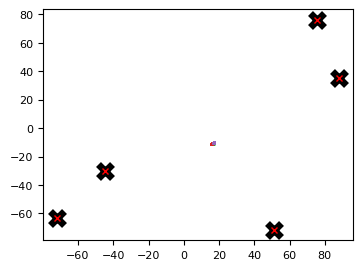

In [168]:
plot_data(cent+4, X, n_samples)

In [162]:
def meanshift(data, func):
    X = data.clone()
    for i in range(3):
        weights = calculate_weights(X, func)
        X = update_X(X, weights)
    return X

In [163]:
%timeit -n 2 _ = meanshift(dat, gaussian)

65.8 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [164]:
X = meanshift(dat, partial(gaussian,sig=10))

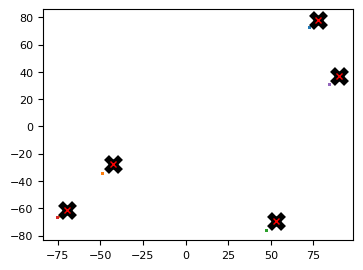

In [165]:
plot_data(cent+6, X, n_samples)

In [106]:
X = meanshift_slow(dat)

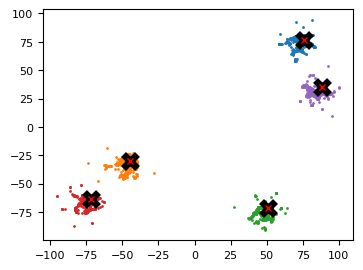

In [107]:
plot_data(cent+4, X, n_samples)

### *--- Quick drafting ---*

In [327]:
A = torch.tensor([0, 1, 2])

B = torch.tensor([[ 0,  1,  2,  3],
                  [ 4,  5,  6,  7],
                  [ 8,  9, 10, 11]])

In [328]:
A.shape, A[:,None].shape, B.shape

(torch.Size([3]), torch.Size([3, 1]), torch.Size([3, 4]))

In [329]:
A[:,None]*B, B*A[:,None]

(tensor([[ 0,  0,  0,  0],
         [ 4,  5,  6,  7],
         [16, 18, 20, 22]]),
 tensor([[ 0,  0,  0,  0],
         [ 4,  5,  6,  7],
         [16, 18, 20, 22]]))

In [265]:
(A[:,None]*B).sum(0), (A[:,None]*B).sum(1)

(tensor([20, 23, 26, 29]), tensor([ 0, 22, 76]))

In [270]:
torch.einsum('ij,ij->j',A[:,None],B), torch.einsum('ij,ij->i',A[:,None],B)

(tensor([20, 23, 26, 29]), tensor([ 0, 22, 76]))

Build the data and calculate the distances between each point and the rest of the points ( (n,n) difference) 

In [227]:
def samp(x): return torch.distributions.MultivariateNormal(x, torch.diag(torch.tensor([5.,5.]))).sample((10,))

In [228]:
samp(tensor([1.,2.]))

tensor([[ 0.886,  3.895],
        [-2.326,  3.220],
        [ 2.753, -0.873],
        [-3.342, -0.368],
        [ 5.698,  1.526],
        [ 0.465, -1.162],
        [ 2.884,  4.054],
        [ 8.553,  2.259],
        [-1.068,  2.933],
        [ 4.434,  4.213]])

In [222]:
samp.shape

torch.Size([10, 2])

In [225]:
cetr = torch.rand(5,2)

In [226]:
cetr

tensor([[0.374, 0.704],
        [0.107, 0.632],
        [0.842, 0.346],
        [0.499, 0.646],
        [0.352, 0.100]])

In [229]:
datt_l = [samp(c) for c in cetr]
datt =  torch.cat(datt_l)

In [230]:
datt.shape

torch.Size([50, 2])

In [235]:
(datt[:,None,:] - datt).shape

torch.Size([50, 50, 2])

In [237]:
#calc dist between each poitn and the rest
Di = datt[:,None,:] - datt
diss = torch.einsum('ijk,ijk->ij', Di, Di).sqrt()

In [239]:
diss.shape

torch.Size([50, 50])

In [243]:
rd = torch.zeros_like(diss)
for i, d in enumerate(datt):
    rd[i] = ((d-datt)**2).sum(1).sqrt()

In [248]:
(diss+1-rd).sum()

tensor(2500.)

In [254]:
def delta_equal(u, v, delta=1e-6):
    if (u-v).sum() < delta: return True
    else: return False

In [255]:
delta_equal(diss+1, rd)

False

In [512]:
A = tensor([[1,0],[1,0],[-1,0]])

B = tensor([[1, 2, 3],
            [4, 5, 6],
            [7, 8, 9]])

In [513]:
A, B

(tensor([[ 1,  0],
         [ 1,  0],
         [-1,  0]]),
 tensor([[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]))

In [514]:
A.shape, B.shape, A[...,None].shape, B[:,None,:].shape

(torch.Size([3, 2]),
 torch.Size([3, 3]),
 torch.Size([3, 2, 1]),
 torch.Size([3, 1, 3]))

In [515]:
A*B[...,None]

tensor([[[ 1,  0],
         [ 2,  0],
         [-3,  0]],

        [[ 4,  0],
         [ 5,  0],
         [-6,  0]],

        [[ 7,  0],
         [ 8,  0],
         [-9,  0]]])